### IMPORT LIBRARIES

In [126]:
import os
import numpy as np
import wfdb
import cv2 as cv2
from wfdb import processing
import pandas as pd
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Signals dsp
from scipy.signal import butter, lfilter, iirfilter
from IPython.display import display
from scipy.signal import freqz
from scipy import signal

# Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Pytorch
import torch

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Flatten, BatchNormalization, Activation,
    Conv1D, MaxPooling1D, GlobalAveragePooling1D, AveragePooling1D,
    Conv2D, MaxPooling2D, ZeroPadding2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import plot_model

### TEST DATA PREPROCESING

In [2]:
# Data dir
mitdb_path = r"./Dataset/mitdb"

In [7]:
record = wfdb.rdsamp(mitdb_path + '/124')
annotation = wfdb.rdann(mitdb_path+ '/124', 'atr')

In [4]:
if os.path.isdir(mitdb_path):
  print('You already have the data.')

You already have the data.


### FUNCTIONS: PREPROCESSING

In [148]:
# ============================================
# Function: butter_bandpass
# Description:
#   Designs a Butterworth bandpass filter with given cutoff frequencies 
#   and sampling frequency, using scipy's butter function.
#
# Parameters:
#   lowcut : float
#       Lower cutoff frequency of the bandpass filter in Hz
#   highcut : float
#       Upper cutoff frequency of the bandpass filter in Hz
#   fs : float
#       Sampling frequency in Hz
#   order : int, optional (default=3)
#       Order of the Butterworth filter
#
# Returns:
#   b : ndarray
#       Numerator coefficients of the filter
#   a : ndarray
#       Denominator coefficients of the filter
# ============================================
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs                      # Nyquist frequency (half the sampling rate)
    low = lowcut / nyquist                  # Normalize lower cutoff frequency
    high = highcut / nyquist                # Normalize upper cutoff frequency
    b, a = butter(order, [low, high], btype='band')  # Design bandpass filter
    return b, a                             # Return the filter coefficients

# ============================================
# Function: IIR filter (manual implementation using difference equation)
# Description:
#   Applies the IIR filter using the manually coded difference equation
#   for the given signal and filter coefficients (b, a).
#
# Parameters:
#   s_in : array-like
#       Input signal to be filtered
#   a : array-like
#       Denominator (feedback) coefficients of the IIR filter
#   b : array-like
#       Numerator (feedforward) coefficients of the IIR filter
#
# Returns:
#   y : array-like
#       Filtered output signal of the same length as s_in
# ============================================
def iir_filter(s_in, a, b):
    N = len(s_in)              # Total number of input samples
    y = np.zeros(N)            # Initialize the output signal to zeros

    for n in range(N):
        # Feedforward part (numerator)
        for j in range(len(b)):
            if n - j >= 0:
                y[n] += b[j] * s_in[n - j]  # Add feedforward terms

        # Feedback part (denominator), skip a[0] since it is typically 1
        for j in range(1, len(a)):
            if n - j >= 0:
                y[n] -= a[j] * y[n - j]  # Subtract feedback terms

    return y  # Return the filtered signal

# ============================================
# Function: iir_bandpass_filter
# Description:
#   Applies a bandpass filter to the signal using the IIR filter 
#   designed by butter_bandpass() and applied with the iir_filter().
#
# Parameters:
#   data : array-like
#       Input ECG signal to be filtered
#   lowcut : float
#       Lower cutoff frequency in Hz for the bandpass filter
#   highcut : float
#       Upper cutoff frequency in Hz for the bandpass filter
#   fs : float
#       Sampling frequency in Hz
#   order : int, optional (default=5)
#       Order of the Butterworth filter
#
# Returns:
#   y : array-like
#       Filtered ECG signal after applying the IIR bandpass filter
# ============================================
def iir_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order)  # Get filter coefficients
    y = iir_filter(data, a, b)  # Apply the IIR filter to the data
    return y  # Return the filtered signal

# ============================================
# Function: normalize
# Description:
#   Normalizes the input signal to the range [0, 1].
#
# Parameters:
#   sig : array-like
#       Input signal to be normalized
#
# Returns:
#   normalized_sig : array-like
#       Normalized signal, scaled between 0 and 1
# ============================================
def normalized(sig):
    normalized_sig = (sig - np.min(sig)) / (np.max(sig) - np.min(sig))  # Scale the signal
    return normalized_sig  # Return the normalized signal

# ============================================
# Function: DynamicSegmentation
# Description:
#   Segments the ECG signal into individual heartbeats based on detected R-peaks.
#   The segment length is dynamically determined by the RR interval.
#
# Parameters:
#   peaksIndecies : array-like
#       Indices of detected R-peaks in the ECG signal
#   signal : array-like
#       The input ECG signal from which the beats are extracted
#
# Returns:
#   beats : list
#       A list of segmented heartbeats, each containing the corresponding portion
#       of the ECG signal based on the R-peak and surrounding RR intervals.
# ============================================
def DynamicSegmentation(peaksIndecies, signal):
    beats = [[]]
    beats.remove([])  # Remove the empty list that was initialized
    for i in range(1, len(peaksIndecies) - 1):
        RRPrev = peaksIndecies[i] - peaksIndecies[i - 1]  # Previous RR interval
        RRNext = peaksIndecies[i + 1] - peaksIndecies[i]  # Next RR interval
        RRMax = max(RRPrev, RRNext)  # Use the maximum RR interval for flexibility
        start = peaksIndecies[i] - int((1 / 3.0) * RRMax)  # Calculate the start of the beat
        end = peaksIndecies[i] + int((2 / 3.0) * RRMax)    # Calculate the end of the beat
        beats.append(signal[start:end])  # Add the segment to the beats list
    return beats  # Return the list of segmented beats

# ============================================
# Function: resampling
# Description:
#   Resamples each beat to a fixed sample rate to make the beats of uniform length.
#
# Parameters:
#   beats : list
#       List of segmented beats (ECG segments)
#   samprate : int
#       The desired sample rate for the resampling
#
# Returns:
#   resampled : list
#       A list of resampled beats, all of uniform length
# ============================================
def resampling(beats, samprate):
    resampled = [[]]
    resampled.remove([])  # Remove the empty list that was initialized
    for i in beats:
        resampled.append(list(signal.resample(i, samprate)))  # Resample each beat to the target rate
    return resampled  # Return the list of resampled beats

In [149]:
# ============================================================
# Function: PreProcessing
# Description:
#   Complete ECG signal preprocessing pipeline including:
#   - Bandpass filtering
#   - Normalization
#   - R-peak detection (if not provided)
#   - Dynamic segmentation of heartbeats
#   - Resampling of each heartbeat to fixed length
#
# Parameters:
#   signal : array-like
#       Raw ECG signal (typically from d_signal)
#   fs : int, optional (default=360)
#       Sampling frequency of the ECG signal
#   datasetinds : list or None
#       Optional: pre-computed list of R-peak indices.
#       If None, the function will detect R-peaks using xqrs.
#
# Returns:
#   beats : list of arrays
#       List of resampled heartbeat segments, ready for CNN input
# ============================================================
def PreProcessing(signal, fs=360, datasetinds=None):

    # Step 1: Apply IIR bandpass filter (default: 0.35–40 Hz, order 2)
    filteredSig = iir_bandpass_filter(signal, 0.35, 40, fs, order=2)

    # Step 2: Normalize the filtered signal to range [0, 1]
    filteredSig = normalized(filteredSig)

    # Step 3: Detect QRS peaks if not provided (using WFDB's xqrs)
    if datasetinds is None:
        # If signal has multiple channels, select the first channel
        qrs_inds = processing.xqrs_detect(sig=filteredSig[:, 0], fs=fs)
        beats = DynamicSegmentation(qrs_inds, filteredSig)
    else:
        # If R-peak indices are provided externally
        beats = DynamicSegmentation(datasetinds, filteredSig)

    # Step 4: Resample each beat to a fixed sample rate (default: 300 samples)
    beats = resampling(beats, 300)

    return beats  # Return processed and resampled beats


### FUNCTIONS: PROCESSING DATA FOR ALL RECORDS

In [150]:
# ================================================================
# Function: filterAnnotation
# Description:
#   Filters out only the target annotation symbols from a WFDB
#   annotation object (e.g., N, L, R, A, V, /).
#
# Parameters:
#   annotation : wfdb.Annotation
#       Annotation object from WFDB record
#
# Returns:
#   annotations : list of str
#       Filtered list of beat class symbols
#   RPeaksInds : list of int
#       Corresponding sample indices of the selected R-peaks
# ================================================================
def filterAnnotation(annotation):
    classes = ['N', 'L', 'R', 'A', 'V', '/']
    annotations = []
    RPeaksInds = []
    for ann in range(len(annotation.symbol)):
        if annotation.symbol[ann] in classes:
            annotations.append(annotation.symbol[ann])
            RPeaksInds.append(annotation.sample[ann])
    return annotations, RPeaksInds

# def AppendBeatsOfSignalToFile(beats,filePath):
#   if not os.path.exists(filePath):
#     open(filePath, "w").close()

#   f = open(filePath,"a")
#   for i in range(len(beats)):
#       for j in range(len(beats[i])):
#           f.write(str(beats[i][j][0])+'|')
#       f.write('\n')
#   f.close()
#   return


# ================================================================
# Function: AppendBeatsOfSignalToFile
# Description:
#   Appends segmented and resampled beats to a file.
#   Each beat is written as a line with values separated by '|'.
#
# Parameters:
#   beats : list of beats
#       Each beat is a resampled list/array of signal points
#   filePath : str
#       Path to output file to save the beats
# ================================================================
def AppendBeatsOfSignalToFile(beats, filePath):
    if not os.path.exists(filePath):
        open(filePath, "w").close()

    f = open(filePath, "a")
    for i in range(len(beats)):
        for j in range(len(beats[i])):
            # If data is nested (e.g., [ [x], [y] ]), take the first value
            if isinstance(beats[i][j], (list, np.ndarray)): 
                f.write(str(beats[i][j][0]) + '|')
            else:
                f.write(str(beats[i][j]) + '|')
        f.write('\n')
    f.close()
    return


# ================================================================
# Function: WriteAnnotationSymbolToFile
# Description:
#   Writes each annotation symbol (e.g., N, L, R, etc.) to a text file,
#   one per line. Skips the first and last symbol (likely to avoid edge artifacts).
#
# Parameters:
#   annotationSymbol : list of str
#       Annotation labels for each beat
#   filepath : str
#       File path to save annotation labels
# ================================================================
def WriteAnnotationSymbolToFile(annotationSymbol, filepath):
    if not os.path.exists(filepath):
        open(filepath, "w").close()
    f = open(filepath, "a")
    for i in range(1, len(annotationSymbol) - 1):
        f.write(str(annotationSymbol[i]) + '\n')
    f.close()
    return


# ================================================================
# Function: PrepareFiles
# Description:
#   Processes multiple MIT-BIH ECG records by:
#   - Loading signals and annotations
#   - Filtering + segmenting + resampling beats
#   - Saving beats and their labels to file
#
# Parameters:
#   filenames : list of str
#       List of record IDs (e.g., ['100', '101', '102'])
#   directory : str
#       Target directory to save results
# ================================================================
def PrepareFiles(filenames, directory):
    print('writing files has been started')
    for i in range(len(filenames)):
        print('Now in record ' + str(filenames[i]))
        # Load annotation and extract filtered R-peaks
        annotation = wfdb.rdann(r'./Dataset/mitdb/' + str(filenames[i]), 'atr')
        annotation.symbol, annotation.sample = filterAnnotation(annotation)
        # Load raw ECG signal (channel 0)
        sig, fields = wfdb.rdsamp(r'./Dataset/mitdb/' + str(filenames[i]), channels=[0], sampfrom=0, sampto=None)
        # Preprocess (filter → normalize → segment → resample)
        beats = PreProcessing(sig, fields['fs'], annotation.sample)

        # Save processed beats and corresponding labels
        AppendBeatsOfSignalToFile(beats, directory + 'mitdbAllBeats.txt')
        WriteAnnotationSymbolToFile(annotation.symbol, directory + 'mitdbAllAnnotationsSymbols.txt')
    print('done')


# ================================================================
# Function: ClusteringBeatsInFiles
# Description:
#   Splits preprocessed beats from file into separate files by class label.
#
# Parameters:
#   BeatsFilePath : str
#       Path to the text file containing beat data
#   AnnotationFilePath : str
#       Path to the annotation labels corresponding to each beat
#   directory : str
#       Output directory to save per-class beat files
# ================================================================
def ClusteringBeatsInFiles(BeatsFilePath, AnnotationFilePath, directory):
    classes = ['N', 'L', 'R', 'A', 'V', '/']
    bf = open(BeatsFilePath, "r")
    annf = open(AnnotationFilePath, "r")
    beats = bf.readlines()
    annotations = annf.readlines()
    print(len(beats))
    print(len(annotations))

    # Prepare containers for each beat class
    b = {}
    files = {
        'N': 'Normal',
        'L': 'Left_bundle_branch_block',
        'R': 'Right_bundle_branch_block',
        'A': 'Atrial_premature',
        'V': 'Premature_ventricular_contraction',
        '/': 'Paced'
    }
    for i in classes:
        b[i] = []

    # Assign beats to corresponding class
    for i in range(len(beats)):
        beat_class = annotations[i].strip()
        if beat_class in b:
            b[beat_class].append(beats[i])

    # Write beats per class to separate files
    for ann, bts in b.items():
        f = open(directory + files[ann] + '.txt', "w")
        f.writelines(bts)
        f.close()

In [151]:
all_records = [100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
             111, 112, 113, 114, 115, 116, 117, 118, 119, 121,
             122, 123, 124, 200, 201, 202, 203, 205, 207, 208,
             209, 210, 212, 213, 214, 215, 217, 219, 220, 221,
             222, 223, 228, 230, 231, 232, 233, 234]

train_records = [101,102, 104, 106,108,109,112,114,115,116,118,119,122,124,201,203,205,207,208,209,215,220,223,230]
test_records = [100,103,105,107, 111,113,117,121,123,200,202,210,212,213,214, 217,219,221,222,228,231,232,233,234]

In [152]:
data_dir = r'./Data_00/'
train_dir = data_dir + r'/Train/'
test_dir = data_dir + r'/Test/'
PrepareFiles(train_records,train_dir)
PrepareFiles(test_records,test_dir)

ClusteringBeatsInFiles(train_dir+'mitdbAllBeats.txt' , train_dir+'mitdbAllAnnotationsSymbols.txt',train_dir)
ClusteringBeatsInFiles(test_dir+'mitdbAllBeats.txt' , test_dir+'mitdbAllAnnotationsSymbols.txt',test_dir)

writing files has been started
Now in record 101


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 102


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 104


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 106


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 108


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 109


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 112


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 114


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 115


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 116


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 118


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 119


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 122


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 124


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 201


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 203


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 205


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 207


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 208


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 209


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 215


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 220


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 223


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 230


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


done
writing files has been started
Now in record 100


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 103


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 105


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 107


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 111


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 113


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 117


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 121


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 123


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 200


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 202


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 210


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 212


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 213


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 214


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 217


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 219


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 221


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 222


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 228


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 231


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 232


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 233


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


Now in record 234


C:\Users\AD\AppData\Local\Temp\ipykernel_3988\1434268807.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] += b[j] * s_in[n - j]  # Add feedforward terms


done
161865
161865
159117
159117


In [153]:
# ============================================================
# Function: One_Hot_Encoded_Y
# Description:
#   Creates a one-hot encoded label array for a given class.
#
# Parameters:
#   classNumber : int
#       The zero-based index of the class (e.g., 0 for 'N', 1 for 'L', etc.)
#   NumberOfClasses : int
#       Total number of classes (e.g., 6 for ECG classification)
#   NumberOfSamples : int
#       Number of samples in this class
#
# Returns:
#   Y : ndarray
#       One-hot encoded label array of shape (NumberOfSamples, NumberOfClasses)
# ============================================================
def One_Hot_Encoded_Y(classNumber, NumberOfClasses, NumberOfSamples):
    if NumberOfSamples == 0:
        return np.empty((0, NumberOfClasses))
    Yi = np.zeros(NumberOfClasses)
    Yi[classNumber] = 1
    Y = np.vstack([Yi] * NumberOfSamples)
    return Y

# ============================================================
# Function: ReadClassData
# Description:
#   Reads data from a .txt file and returns X (features) and Y (labels)
#   where X is the signal samples and Y is one-hot encoded label.
#
# Parameters:
#   path : str
#       Path to the .txt file containing beat data (one beat per line)
#   ZeroBased_classNumber : int
#       The class index used for one-hot encoding
#   NumOfClasses : int
#       Total number of target classes
#
# Returns:
#   X : ndarray
#       Input features of shape (num_samples, num_timesteps)
#   Y : ndarray
#       One-hot encoded labels of shape (num_samples, NumOfClasses)
# ============================================================
def ReadClassData(path, ZeroBased_classNumber, NumOfClasses):
    with open(path, "r") as f:
        Data = f.readlines()

    X = []
    for i, line in enumerate(Data):
        row = line.strip().split('|')  # Remove \n and split by '|'
        if '' in row:
            row.remove('')  # Remove empty string at end (due to trailing '|')
        try:
            row = list(map(float, row))
            X.append(row)
        except ValueError:
            print(f"Skipped invalid line {i}: {line[:50]}")

    # Filter only rows with correct length (optional, e.g., 300 points)
    expected_len = len(X[0]) if len(X) > 0 else 0
    X = [r for r in X if len(r) == expected_len]

    X = np.array(X)
    if X.shape[0] == 0:
        X = np.empty((0, expected_len))  # Return empty but shaped

    Y = One_Hot_Encoded_Y(ZeroBased_classNumber, NumOfClasses, X.shape[0])
    return X, Y

# ============================================================
# Function: Prepare_Category
# Description:
#   Combines training and testing data for a given class and creates
#   the corresponding one-hot encoded labels.
#
# Parameters:
#   ClassesTrainData : list of arrays
#       List of training data arrays per class
#   ClassesTestData : list of arrays
#       List of test data arrays per class
#   classNumber : int
#       The class index for one-hot encoding
#   NumberOfCategories : int
#       Total number of classes
#   MultiClassCategory : bool
#       Whether to perform multi-class classification (default: True)
#
# Returns:
#   Ncat_X_train : ndarray
#   Ncat_X_test : ndarray
#   Ncat_Y_train : ndarray
#   Ncat_Y_test : ndarray
# ============================================================
def Prepare_Category(ClassesTrainData, ClassesTestData, classNumber, NumberOfCategories, MultiClassCategory=True):
    if MultiClassCategory:
        Ncat_X_train = np.concatenate(ClassesTrainData, axis=0)
        Ncat_X_test = np.concatenate(ClassesTestData, axis=0)
    else:
        print('category of one class')
        Ncat_X_train = ClassesTrainData
        Ncat_X_test = ClassesTestData

    Ncat_Y_train = One_Hot_Encoded_Y(classNumber, NumberOfCategories, Ncat_X_train.shape[0])
    Ncat_Y_test = One_Hot_Encoded_Y(classNumber, NumberOfCategories, Ncat_X_test.shape[0])

    # Optional: shuffle data if needed
    # from sklearn.utils import shuffle
    # Ncat_X_train, Ncat_Y_train = shuffle(Ncat_X_train, Ncat_Y_train)
    # Ncat_X_test, Ncat_Y_test = shuffle(Ncat_X_test, Ncat_Y_test)

    return Ncat_X_train, Ncat_X_test, Ncat_Y_train, Ncat_Y_test

# ============================================================
# Function: Model_Y
# Description:
#   Builds a complete Y label array for all classes based on how many
#   samples each class has. This is useful when combining class-wise data.
#
# Parameters:
#   NumberOfSamplesEachClass : list of int
#       Number of samples in each class, indexed by class
#
# Returns:
#   Y : ndarray
#       Combined one-hot encoded label array for all samples
# ============================================================
def Model_Y(NumberOfSamplesEachClass=[]):
    NumberOfClasses = len(NumberOfSamplesEachClass)
    Ys = []
    for i in range(NumberOfClasses):
        Ys.append(One_Hot_Encoded_Y(i, NumberOfClasses, NumberOfSamplesEachClass[i]))
    Y = np.concatenate(tuple(Ys), axis=0)
    return Y

### LOAD DATA IN TEXT FILES FOR TRAIN MODEL

In [154]:
files = {'N':'Normal',
          'L':'Left_bundle_branch_block',
          'R':'Right_bundle_branch_block',
          'A':'Atrial_premature',
          'V':'Premature_ventricular_contraction',
          '/':'Paced'}
directory_train   = './Data_00/Train/'
directory_test    = './Data_00/Test/'

shuff = True
NumOfClasses = 6

path = directory_train + files['N'] + '.txt'
XN_train , YN_train = ReadClassData(path,0,NumOfClasses)
path = directory_test + files['N'] + '.txt'
XN_test , YN_test = ReadClassData(path,0,NumOfClasses)


path = directory_train + files['L'] + '.txt'
XL_train , YL_train = ReadClassData(path,1,NumOfClasses)
path = directory_test + files['L'] + '.txt'
XL_test , YL_test = ReadClassData(path,1,NumOfClasses)


path = directory_train + files['R'] + '.txt'
XR_train , YR_train = ReadClassData(path,2,NumOfClasses)
path = directory_test + files['R'] + '.txt'
XR_test , YR_test = ReadClassData(path,2,NumOfClasses)

path = directory_train + files['A'] + '.txt'
XA_train , YA_train = ReadClassData(path,3,NumOfClasses)
path = directory_test + files['A'] + '.txt'
XA_test , YA_test = ReadClassData(path,3,NumOfClasses)


path = directory_train + files['V'] + '.txt'
XV_train , YV_train = ReadClassData(path,4,NumOfClasses)
path = directory_test + files['V'] + '.txt'
XV_test , YV_test = ReadClassData(path,4,NumOfClasses)


path = directory_train + files['/'] + '.txt'
XP_train , YP_train = ReadClassData(path,5,NumOfClasses)
path = directory_test + files['/'] + '.txt'
XP_test , YP_test = ReadClassData(path,5,NumOfClasses)

In [155]:
X_TRAIN= np.concatenate((XA_train,XL_train,XN_train,XR_train,XV_train,XP_train), axis=0)
Y_TRAIN= np.concatenate((YA_train,YL_train,YN_train,YR_train,YV_train,YP_train), axis=0)

X_TEST= np.concatenate((XA_test,XL_test,XN_test,XR_test,XV_test,XP_test), axis=0)
Y_TEST= np.concatenate((YA_test,YL_test,YN_test,YR_test,YV_test,YP_test), axis=0)

X_train , Y_train = shuffle(X_TRAIN , Y_TRAIN)
X_test,Y_test = shuffle( X_TEST,Y_TEST)
X_train = np.expand_dims(X_train,axis=-1)
X_test = np.expand_dims(X_test,axis=-1)

In [ ]:
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)

X_train: (53955, 24, 1)
Y_train: (53955, 6)


In [139]:
from sklearn.utils import class_weight
# Convert one-hot Y_train to class indices
y_train_labels = np.argmax(Y_train, axis=1)

# Compute balanced class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights = dict(enumerate(class_weights))

### MODEL ARCHITECTURE

In [143]:
# ============================================================
# Function: ECG_MODEL
# Description:
#   Defines a 1D CNN model for ECG beat classification.
#   Based on lightweight architecture for potential VLSI implementation.
#
# Parameters:
#   nclass : int
#       Number of output classes (default is 6 for MIT-BIH ECG beats)
#
# Returns:
#   model : keras.Model
#       Compiled Keras model ready for training
# ============================================================
def ECG_MODEL(nclass=6):
    # Input shape: (300, 1) → 300 time steps, 1 channel
    inp = Input(shape=(300, 1))  # Input: ECG beat with 300 points

    # First convolutional layer: 3 filters, kernel size 7
    lay = Conv1D(3, kernel_size=7, activation='relu', padding="same")(inp)  # Output: (300, 3)

    # Downsampling: halve the temporal resolution → (150, 3)
    lay = MaxPooling1D(pool_size=2)(lay)

    # 1×1 convolution: reduce dimensionality / reweight features → (150, 1)
    lay = Conv1D(1, kernel_size=1, activation='relu', padding="same")(lay)

    # Second convolution layer: extract deeper features → (150, 3)
    lay = Conv1D(3, kernel_size=7, activation='relu', padding="same")(lay)

    # Further downsampling: reduce temporal length → (50, 3)
    lay = MaxPooling1D(pool_size=3)(lay)

    # Flatten into 1D vector: 50 × 3 = 150
    flat = Flatten()(lay)

    # Fully connected layer: 21 neurons (from paper)
    dense_1 = Dense(21, activation='relu')(flat)

    # Output layer: softmax across 6 classes
    dense_2 = Dense(nclass, activation='softmax')(dense_1)

    # Build and compile the model
    model = Model(inputs=inp, outputs=dense_2)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=CategoricalCrossentropy(),
        metrics=['acc']
    )

    model.summary()
    return model


In [144]:
model = ECG_MODEL()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 300, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_51 (Conv1D)              │ (None, 300, 3)         │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_34 (MaxPooling1D) │ (None, 150, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_52 (Conv1D)              │ (None, 150, 1)         │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_53 (Conv1D)              │ (None, 150, 3)         │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ (None, 50, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 21)             │         3,171 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 6)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,355 (13.11 KB)

 Trainable params: 3,355 (13.11 KB)

 Non-trainable params: 0 (0.00 B)

### PARAMETERS & TRAIN MODEL

In [145]:
# Parameters
epochs = 100
batch_size = 64

# Train model
# history = model.fit(X_train, Y_train,
#                     validation_data=(X_test, Y_test),
#                     epochs=epochs,
#                     batch_size=batch_size,
#                     verbose=1)
history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=epochs,
                    batch_size=batch_size,
                    class_weight=class_weights,
                    verbose=1)

Epoch 1/100


ValueError: Input 0 of layer "functional_17" is incompatible with the layer: expected shape=(None, 300, 1), found shape=(None, 24)

### FUNCTIONS: MODEL EVALUTION

In [16]:
# ============================================================
# Function: Build_Confusion_Matrix
# Description:
#   Constructs a confusion matrix from ground truth and predicted class labels.
#
# Parameters:
#   y_test : array-like
#       Ground truth labels (integer class indices)
#   y_pred : array-like
#       Predicted labels (integer class indices)
#   num_of_classes : int
#       Number of total classes
#
# Returns:
#   confusion_matrix : ndarray (shape: [num_classes, num_classes])
# ============================================================
def Build_Confusion_Matrix(y_test, y_pred, num_of_classes):
    confusion_matrix = np.zeros((num_of_classes, num_of_classes))
    for i in range(len(y_test)):
        confusion_matrix[y_test[i], y_pred[i]] += 1
    return confusion_matrix

# ============================================================
# Function: Calculate_Accuracy
# Description:
#   Calculates per-class accuracy, overall accuracy,
#   and average per-class accuracy from confusion matrix.
#
# Parameters:
#   confusion_matrix : ndarray
#       Confusion matrix from Build_Confusion_Matrix()
#
# Returns:
#   acc : float
#       Overall classification accuracy (%)
#   average_accuracy : float
#       Mean of class-wise accuracy (%)
# ============================================================
def Calculate_Accuracy(confusion_matrix):
    acc = (np.sum(confusion_matrix.diagonal()) / np.sum(confusion_matrix)) * 100  # Overall accuracy
    accuracies = []
    for i in range(len(confusion_matrix)):
        class_count = confusion_matrix[i, i]
        if class_count == 0:
            accuracies.append(0)  # If no correct samples for that class
        else:
            ac = (confusion_matrix[i, i] / np.sum(confusion_matrix[i, :])) * 100
            accuracies.append(ac)
    print("Per-class accuracy (%):", accuracies)
    average_accuracy = np.average(accuracies)
    print('Average Accuracy:', average_accuracy)
    print('Overall Accuracy:', acc)
    return acc, average_accuracy


# ============================================================
# Function: Evaluate
# Description:
#   Evaluates prediction results using confusion matrix and accuracy metrics.
#
# Parameters:
#   y_test : array-like
#       Ground truth labels
#   y_pred : array-like
#       Predicted labels
#   num_of_classes : int
#       Total number of classes
#
# Returns:
#   acc : float
#   average_accuracy : float
# ============================================================
def Evaluate(y_test, y_pred, num_of_classes):
    confusion_matrix = Build_Confusion_Matrix(y_test, y_pred, num_of_classes)
    confusion_matrix = np.int64(confusion_matrix)  # Ensure it's integer type
    print(confusion_matrix)  # Display raw confusion matrix
    return Calculate_Accuracy(confusion_matrix)



# ============================================================
# Function: Predict_and_Evaluate
# Description:
#   Performs prediction using the model, converts outputs to class indices,
#   and evaluates using a confusion matrix.
#
# Parameters:
#   model : keras.Model
#       Trained classification model
#   X_test : ndarray
#       Input features for testing
#   Y_test : ndarray
#       Ground truth one-hot labels
#   NumOfClasses : int
#       Total number of output classes
#
# Returns:
#   acc, average_accuracy : float
# ============================================================
def Predict_and_Evaluate(model, X_test, Y_test, NumOfClasses):
    Y_predict = model.predict(X_test)  # Softmax output
    inds = np.argmax(Y_test, axis=1)   # Convert one-hot ground truth to class indices
    pred = np.argmax(Y_predict, axis=1)  # Convert prediction to class indices
    accuracy = np.mean(inds == pred)  # Raw accuracy
    print("Raw prediction accuracy:", accuracy)
    return Evaluate(inds, pred, NumOfClasses)


# ============================================================
# Function: Plot_Confusion_Matrix
# Description:
#   Plots a colored confusion matrix using seaborn heatmap.
#
# Parameters:
#   confusion_matrix : ndarray
#       Matrix of shape [n_classes, n_classes]
#   class_names : list of str
#       Class labels (e.g., ['N', 'L', 'R', 'A', 'V', '/'])
# ============================================================
def Plot_Confusion_Matrix(confusion_matrix, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [110]:
num_of_classes = 6

### RESULTS

In [120]:
accuracy, avg_accuracy = Predict_and_Evaluate(model, X_test, Y_test, NumOfClasses)

1658/1658 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Raw prediction accuracy: 0.3781179886498614
[[16556   249   639  9220  8596  1395]
 [  939   157    10   664  1875   477]
 [ 2332     0    11    50   681   398]
 [  718     1    76    75   723   142]
 [  174    75   100   418  2594    78]
 [  187   938    11   334  1484   662]]
Per-class accuracy (%): [45.16709862228891, 3.808830664725861, 0.31682027649769584, 4.322766570605188, 75.42890375109043, 18.307522123893804]
Average Accuracy: 24.55865700151698
Overall Accuracy: 37.81179886498614


In [121]:
Y_predict = model.predict(X_test)
y_pred = np.argmax(Y_predict, axis=1)
y_test = np.argmax(Y_test, axis=1)

1658/1658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [122]:
conf_matrix = Build_Confusion_Matrix(y_test, y_pred, NumOfClasses)

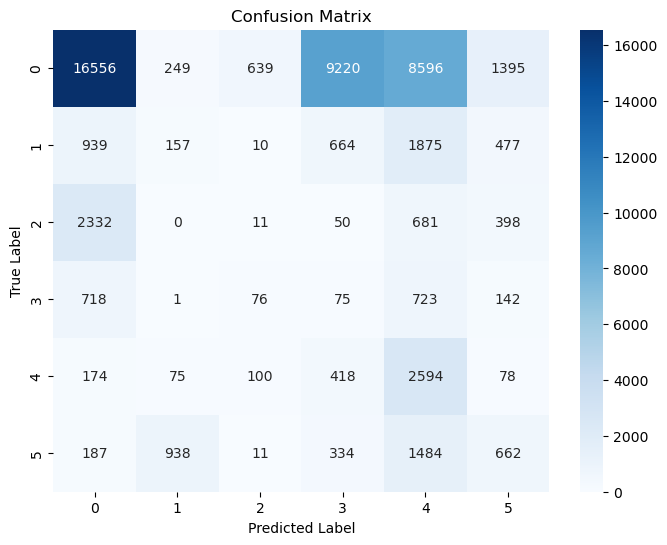

In [123]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=range(NumOfClasses), yticklabels=range(NumOfClasses))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("./Output_01/confusion_matrix.png")  # Lưu hình ảnh
plt.show()

In [124]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)

1658/1658 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.3805 - loss: 3.3330


In [125]:
model.save(r"./Output_01/ecg_model.h5")

np.savez(r"./Output_01/model_results.npz",
         confusion_matrix=conf_matrix,
         accuracy=test_accuracy,
         loss=test_loss)

with open(r"./Output_01/model_metrics.pkl", "wb") as f:
    pickle.dump({"confusion_matrix": conf_matrix, "accuracy": test_accuracy, "loss": test_loss}, f)
